In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import eyecite
from datetime import datetime
from markdown import markdown
from IPython.display import Markdown, display, HTML
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
load_dotenv()
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from typing import Tuple, Optional
from src.schema.decisions import Decision
from src.schema.decisions import extract_parallel_citation_context, filter_decisions_by_forward_citations
from src.doc_store.cap_client import CAPClient
from src.doc_store.cap import Cap
from src.doc_store.cl_client  import CourtListenerClient
from src.utils.citations import create_highlighted_citation
from src.doc_store.base import process_citations_with_progress
from src.doc_store.utils import (
    load_models_from_json, 
    save_models_to_json, 
    looks_like_case_law_link, 
    filter_decisions_with_text,
)

In [3]:
cl_client = CourtListenerClient()
cap_client = CAPClient()

In [4]:
cap_docket_search = cap_client.search_cases(search_term="Liberty Mutual", full_case=True)

* The `Decision` data model is based on the CAP API, but it also (mostly) works with Court Listener API data

In [5]:
decisions = [Decision(**result) for result in cap_docket_search["results"]]

In [6]:
decisions[0].casebody.status

'error_limit_exceeded'

In [7]:
decisions = load_models_from_json(Decision, "./data/models/top_four.json")
len(decisions)

169

* Example of CAP data

In [8]:
decisions[100].model_dump()

{'decision_date': '2010-03-31',
 'name': 'ASSOCIATED AUTOMOTIVE INC., Plaintiff, v. ACCEPTANCE INDEMNITY INSURANCE COMPANY, Defendant',
 'name_abbreviation': 'Associated Automotive Inc. v. Acceptance Indemnity Insurance',
 'docket_num': None,
 'citations': [{'cite': '705 F. Supp. 2d 714',
   'reporter': None,
   'category': 'official',
   'case_ids': []}],
 'parties': [],
 'attorneys': None,
 'first_page': 714,
 'last_page': 727,
 'court': {'id': 9171,
  'name': 'United States District Court for the Southern District of Texas',
  'url': 'https://api.case.law/v1/courts/sd-tex/',
  'whitelisted': None,
  'name_abbreviation': 'S.D. Tex.'},
 'casebody': {'data': '<section class="casebody" data-case-id="32044132249814_0054" data-firstpage="714" data-lastpage="727">\n  <section class="head-matter">\n    <h4 class="parties" id="b754-10" data-blocks=\'[["BL_754.10",754,[1090,1803,567,329]]]\'>ASSOCIATED AUTOMOTIVE INC., Plaintiff, v. ACCEPTANCE INDEMNITY INSURANCE COMPANY, Defendant.</h4>\n   

In [9]:
decisions[0].model_dump()

{'decision_date': '2002-04-30',
 'name': 'Cunningham v. Universal Underwriters, 120 Cal. Rptr. 2d 162, 98 Cal. App. 4th 1141 (Cal. Ct. App. 2002)',
 'name_abbreviation': 'Cunningham',
 'docket_num': 'D038121',
 'citations': [{'cite': '120 Cal. Rptr. 2d 162',
   'reporter': 'Cal. Rptr. 2d',
   'category': 'State',
   'case_ids': [2163227]},
  {'cite': '98 Cal. App. 4th 1141',
   'reporter': 'Cal. App. 4th',
   'category': 'State',
   'case_ids': [2163227]}],
 'parties': [],
 'attorneys': 'Counsel, Callahan, McCune & Willis and Colrena Kay Johnson for Defendant and Appellant., Ault, Davis & Shonfeld, Thomas H. Ault, Gary E. Davis and R. Michael Jordan for Plaintiffs and Respondents.',
 'first_page': None,
 'last_page': None,
 'court': {'id': 2163227,
  'name': 'Cal. Ct. App.',
  'url': 'https://www.courtlistener.com/api/rest/v3/courts/calctapp/',
  'whitelisted': None,
  'name_abbreviation': None},
 'casebody': {'data': {'head_matter': '<docketnumber data-order="0" data-type="docketnumbe

In [5]:
cap_client.download_to_csv(cap_docket_search, 'cap_lm_search_results.csv')

Downloaded 58129 court cases to file cap_lm_search_results.csv.


In [35]:
cap_df = cap_client.read_in_csv('cap_lm_search.csv')
print(f"df shape: {cap_df.shape}")
print(f"unique case names: {cap_df['name'].nunique():,}")
cap_df.head(1)

df shape: (58129, 13)
unique case names: 56,716


,id,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body
0,9468099,"Lauri Jo HARTZ, Plaintiff-Appellant, v. LIBERT...",Hartz v. Liberty Mutual Insurance,2001-10-29,8954,United States Court of Appeals for the Fourth ...,4th-cir,"['Before WILKINSON, Chief Judge, and WILKINS a...","['ARGUED: C. William Michaels, Baltimore, MD, ...","[{'type': 'official', 'cite': '269 F.3d 474'}]",https://api.case.law/v1/cases/9468099/,"Lauri Jo HARTZ, Plaintiff-Appellant, v. LIBERT...",Affirmed by published opinion. Chief Judge WIL...


In [36]:
cap_df['body'].fillna('Missing', inplace=True)
cap_df['decision_date'] = pd.to_datetime(cap_df['decision_date'], errors='coerce')
cap_df.sort_values(by='decision_date', inplace=True)
cap_df['decision_date'].min(), cap_df['decision_date'].max()

(Timestamp('1716-02-18 00:00:00'), Timestamp('2020-07-09 00:00:00'))

<Axes: >

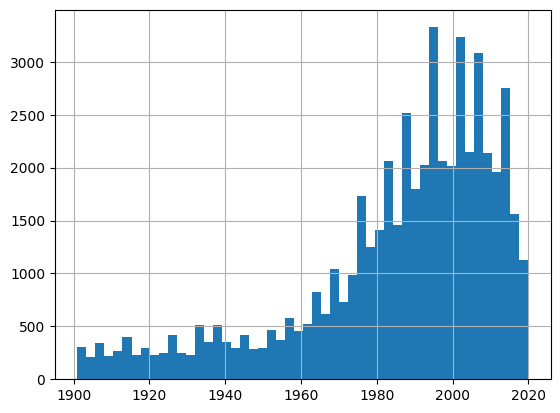

In [37]:
cap_df['year'] = pd.DatetimeIndex(cap_df['decision_date']).year
cap_df['year'] = cap_df['year'].fillna(0).astype(int)
trimmed_df = cap_df[cap_df['year'] > 1900]
trimmed_df['year'].hist(bins=50)

In [92]:
df1 = cap_df[cap_df['year']>=2000]

print(f"df shape: {df1.shape}")
print(f"unique case names: {df1['name'].nunique():,}")
df1.head(2)

df shape: (18965, 14)
unique case names: 18,472


,id,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,year
9178,11234591,"MUTUAL ASSURANCE, INC., Plaintiff, v. Joe F. B...","Mutual Assurance, Inc. v. Banks",2000-01-03,8785,United States District Court for the Southern ...,sd-miss,Missing,Missing,"[{'type': 'official', 'cite': '113 F. Supp. 2d...",https://api.case.law/v1/cases/11234591/,Missing,Missing,2000
53845,11498859,"Shelly R. TAPP, Plaintiff, v. ST. LOUIS UNIVER...",Tapp v. St. Louis University,2000-01-03,8779,United States District Court for the Eastern D...,ed-mo,Missing,Missing,"[{'type': 'official', 'cite': '78 F. Supp. 2d ...",https://api.case.law/v1/cases/11498859/,Missing,Missing,2000


In [93]:
df1['name_contains_lm'] = df1['name'].apply(lambda x: 'Liberty Mutual' in x or 'LIBERTY MUTUAL' in x)
df1['body_contains_lm'] = df1['body'].apply(lambda x: 'Liberty Mutual' in x or 'LIBERTY MUTUAL' in x)
    
df1['name_contains_lm'].value_counts()

name_contains_lm
False    17137
True      1828
Name: count, dtype: int64

In [94]:
df1['body_contains_lm'].value_counts()

body_contains_lm
False    18125
True       840
Name: count, dtype: int64

In [95]:
# Filtering the dataframe to keep rows where either 'name_contains_lm' or 'body_contains_lm' is True
filtered_df = df1[(df1['name_contains_lm'] == True) | (df1['body_contains_lm'] == True)]

print(f"Filtered df shape: {filtered_df.shape}")
filtered_df.head(2)

Filtered df shape: (2480, 16)


,id,name,name_abbreviation,decision_date,court_id,court_name,court_slug,judges,attorneys,citations,url,head,body,year,name_contains_lm,body_contains_lm
3546,106582,"Nancy RAMIREZ, as Personal Representative of t...","Ramirez v. Dawson Production Partners, Inc.",2000-01-11,9025,Court of Appeals of New Mexico,nm-ct-app,"['BOSSON and ARMIJO, JJ., concur.']","['Timothy J. Cusack, Cusack, Jaramillo, Romero...","[{'type': 'official', 'cite': '128 N.M. 601'},...",https://api.case.law/v1/cases/106582/,2000-NMCA-011\r\n995 P.2d 1043\r\nNancy RAMIRE...,"OPINION\r\nBUSTAMANTE, Judge.\r\n{1} This case...",2000,True,False
30161,411690,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",Johnson v. Halloran,2000-01-13,8837,Illinois Appellate Court,ill-app-ct,[],"['Wolter, Beeman, Lynch & McIntyre, of Springf...","[{'type': 'official', 'cite': '312 Ill. App. 3...",https://api.case.law/v1/cases/411690/,"RICHARD R. JOHNSON, Plaintiff-Appellant and Cr...",JUSTICE HALL\r\ndelivered the opinion of the c...,2000,False,True


In [96]:
filtered_df['court_name'].value_counts().head(10)

court_name
Illinois Appellate Court                                 435
New York Supreme Court, Appellate Division               136
Louisiana Court of Appeal                                123
Louisiana Supreme Court                                  114
Florida District Court of Appeal                          99
United States Court of Appeals for the Fifth Circuit      85
North Carolina Court of Appeals                           50
United States Court of Appeals for the Second Circuit     39
United States Court of Appeals for the Third Circuit      36
Illinois Supreme Court                                    36
Name: count, dtype: int64

In [56]:
la_third = filtered_df[filtered_df['court_name']=='Court of Appeal of Louisiana, Third Circuit']
la_third = la_third[la_third['year']>2017]
la_third.sort_values(by='decision_date', inplace=True)
la_third.shape

(14, 16)

In [70]:
sample_test = la_third['body'].sample(1).tolist()[0]

Markdown(sample_test[:2000])

AMY, Judge.
This dispute arises from an automobile accident between the plaintiff, Gerald Janise, and William Gerard, who was operating an Acadian Ambulance vehicle at the time of the collision. Following the accident, the plaintiff filed a petition for damages against Mr. Gerard, Acadian Ambulance, and the company's insurer. The jury ultimately found in favor of the defendants, and the plaintiff now appeals. For the following reasons, we affirm.
Factual and Procedural Background
On April 16, 2013, at the intersection of the Evangeline Thruway and Mudd Avenue in Lafayette, the plaintiff, Gerald Janise, was involved in an automobile accident with William Gerard, an operations supervisor for Acadian Ambulance Service, Inc. (hereafter referred to as "Acadian Ambulance"), who was driving a company vehicle. Subsequently, Mr. Janise filed a petition for damages, naming Mr. Gerard, Acadian Ambulance, and their insurer, Liberty Mutual Insurance Company (hereafter referred to as "Liberty Mutual"), as defendants. The petition alleged: "When confronted with a red light ..., William J. Gerard, with wanton disregard and gross negligence, failed to obey the traffic control signal, failed to secure a proper lookout, and failed to proceed through the intersection with caution, thereby causing the collision with Gerald Janise's vehicle." The petition further alleged that, as a result of the collision, the plaintiff sustained bodily injury, particularly to his head, neck, and back. The defendants answered, responding, in pertinent part: "Defendant avers that, by statute, it is entitled to qualified immunity due to the use of the ambulance's lights and siren, and, therefore, may not be held liable in this matter in the absence of gross negligence, which is expressly denied."
Thereafter, the defendants filed a motion for summary judgment, arguing that, under La.R.S. 32:24, which is set forth in pertinent part below, "the driver of an emergency vehicle can be held liable only if his

In [76]:
from typing import List
from typing_extensions import Annotated
from pydantic import BaseModel, Field
from src.utils.pydantic_utils import flatten_pydantic_instance

class AnalysisSection(BaseModel):
    """A concise legal analysis leading to a decision."""
    
    rules: str = Field(
        ...,
        description="Concise explanation of how the Court's considers relevant statutes, interpretations, standards, and tests applicable to this case",
    )
    case_law: str = Field(
        ...,
        description="Names and or citations of cases reviewed by the Court and analysis of how the Court relates those cases to the Issues Presented",
    )
    application: str = Field(
        ...,
        description="Concise explanation of how the Rules and Case Law help the Court reach its conclusions.",
    )


class CaseBrief(BaseModel):
    """A well structured and concise legal case brief."""
    
    case_name: str = Field(
        ...,
        description="The name of the case, if possible include the court and year.",
    )
    issues_presented: str = Field(
        ...,
        description="The issues the Court must resolve",
    )
    facts_of_the_case: str = Field(
        ...,
        description="A concise summary of the facts, parties involved, and the events leading to this case.",
    )
    proceedural_history: str = Field(
        ...,
        description="A district court case summary, appeals court case summary, or otherwise how this issue reached this Court.",
    )
    analysis: AnalysisSection = Field(
        ...,
        description="A legal analysis leading to a decision.",
    )
    conclusion: str = Field(
        ...,
        description="The Court's ruling on the Issues Presented.",
    )
    winner: str = Field(
        ...,
        description="The entity or role that the Court decided in favor of.",
    )
    @property
    def to_pandas(self):
        flat_model = flatten_pydantic_instance(self)
        return pd.DataFrame([flat_model])

    
CaseBrief.model_rebuild()

In [77]:
from tenacity import Retrying, stop_after_attempt, wait_fixed
import instructor
import openai


def generate_case_brief(text: str) -> CaseBrief:
    client = instructor.patch(openai.OpenAI())
    return client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=CaseBrief,
        max_retries=Retrying(
            stop=stop_after_attempt(5),
            wait=wait_fixed(1),
        ),
        messages=[
            {
                "role": "system",
                "content": "You are a world class legal AI specializing in document extraction and summarization.",
            },
            {
                "role": "user",
                "content": f"Compose a case brief using only information from the Context. Working step by step, organize the Context outline into well-structured paragraphs.\n\nHere is the Context: {text}",
            },
        ],
    )

In [78]:
results = []
n = len(la_third)
i = 1

for _, row in la_third.iterrows():
    print(f"Case {i} of {n}:")
    print(f"Analyzing case: {row['name_abbreviation']}, decided on: {str(row['decision_date'])}...")
    text = row['body']
    case_brief = generate_case_brief(text)
    print(f"Ruling favors: {case_brief.winner}")
    case_df = case_brief.to_pandas
    case_df['id'] = row['id']
    results.extend([case_df])
    i += 1

Case 1 of 14:
Analyzing case: Zaunbrecher ex rel. Father v. Martin, decided on: 2018-03-21 00:00:00...
Ruling favors: Defendants/Relators Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux
Case 2 of 14:
Analyzing case: Janise v. Acadian Ambulance Serv., Inc., decided on: 2018-04-25 00:00:00...
Ruling favors: William Gerard, Acadian Ambulance Service, Inc., and Liberty Mutual Insurance Company
Case 3 of 14:
Analyzing case: Talbot v. Mouton Plumbing & Hauling, Inc., decided on: 2018-04-25 00:00:00...
Ruling favors: Partially Talbot, with other issues remanded for further proceedings
Case 4 of 14:
Analyzing case: Ortega v. Cantu Servs., Inc., decided on: 2018-05-02 00:00:00...
Ruling favors: Cantu Services, Inc. and Liberty Mutual Insurance Company
Case 5 of 14:
Analyzing case: Blanchard v. Hicks, decided on: 2018-05-02 00:00:00...
Ruling favors: GoAuto Insurance Company and Demetrius J. Hicks
Case 6 of 14:
Analyzing case: Gaspard v. Horace Mann Ins. Co., decided on: 2018-05-09 00:00:0

In [89]:
results[2]['issues_presented'].tolist()[0]

"(1) Whether the trial court erred in calculating the 'buy back' amount under La.R.S. 23:1102(B).\n(2) Whether Talbot satisfied the necessary 'buy back' amount under La.R.S. 23:1102(B).\n(3) Whether Talbot is entitled to additional credit against future workers' compensation benefits.\n(4) Whether the trial court properly calculated the dollar for dollar credit against future compensation owed by Talbot."

In [91]:
res_df = pd.concat(results)
table_df = res_df.drop(columns=['id'])
table_df['issues_presented'] = table_df['issues_presented'].str.replace("\n", "; ", regex=False)
Markdown(table_df.to_markdown(index=False))

| case_name                                                                                                                                                   | issues_presented                                                                                                                                                                                                                                                                                                                                                                                                        | facts_of_the_case                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | proceedural_history                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | analysis__rules                                                                                                                                                                                                                                                                                                                                                                                                                                                         | analysis__case_law                                                                                                                                                                                                                                                                                                                                                                                                                           | analysis__application                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | conclusion                                                                                                                                                                                                                                                                                                                     | winner                                                                                                         |
|:------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------|
| Zaunbrecher v. Succession of David, et al.                                                                                                                  | Whether the Louisiana Anti-Dram Shop Statute, La.R.S. 9:2800.1, grants statutory immunity to defendants Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux, thereby barring the wrongful death suit arising from a fatal automobile accident caused by an intoxicated individual served alcohol by the defendants.                                                                                                   | On July 11, 2013, Michael Blake Zaunbrecher was killed in a head-on collision with Leo J. David, who was intoxicated. The plaintiff, Zachary Zaunbrecher, filed a suit alleging that David lost control of his vehicle due to his intoxication after being overserved at Paragon Casino Resort, where Marissa Martin served him alcohol, and security guards Nathan Ponthier and Jeremy Ponthieux failed to prevent him from driving away in an intoxicated state.                                                                                                                                                                                                                                   | The trial court dismissed claims against Paragon Casino based on tribal sovereign immunity but was reversed on appeal for the employee defendants. The employees later sought summary judgment based on statutory immunity, which the trial court denied. The employees then filed for supervisory writs challenging the denial of summary judgment.                                                                                                                                         | Under La.R.S. 9:2800.1, a person or entity who sells or serves alcohol is not liable for injuries caused by an intoxicated individual, except when alcohol is provided by force or to minors. Statutory immunity applies to employees of permit holders.                                                                                                                                                                                                                | Louisiana courts, including the Louisiana Supreme Court, have consistently interpreted the statute strictly, denying recovery in similar cases where the statutory conditions for immunity are met.                                                                                                                                                                                                                                          | The defendants have statutory immunity as employees of Paragon, a permit holder. The court found no evidence of force in serving alcohol or service to a minor, thus concluding that the statute applies and bars the suit.                                                                                                                                                                                                                                                                                                           | The writs sought by Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux are granted and made peremptory, dismissing all claims against them with prejudice.                                                                                                                                                                  | Defendants/Relators Marissa Martin, Nathan Ponthier, and Jeremy Ponthieux                                      |
| Gerald Janise v. William Gerard, Acadian Ambulance Service, Inc., and Liberty Mutual Insurance Company                                                      | Whether the jury correctly applied the emergency vehicle statute La.R.S. 32:24, determined Gross Negligence, and followed La.Civ.Code art. 2323 regarding the degree or percentage of negligence.                                                                                                                                                                                                                       | On April 16, 2013, in Lafayette, plaintiff Gerald Janise was involved in a collision with William Gerard of Acadian Ambulance while he was responding to an emergency. Janise sued Gerard, Acadian Ambulance, and their insurer, alleging negligence. The jury found in favor of the defendants, leading Janise to appeal on grounds of misapplication of law and failure to award damages.                                                                                                                                                                                                                                                                                                          | A motion for summary judgment by defendants was denied, proceeding to a jury trial where the jury ruled in favor of defendants. Plaintiff's motion for directed verdict was denied. Post-trial, the defendant's motion for a directed verdict was also denied, and the case was appealed.                                                                                                                                                                                                    | Under La.R.S. 32:24, an emergency vehicle is only liable for reckless disregard. The plaintiff must demonstrate that the emergency vehicle did not follow the statute's provision to qualify as 'responding to an emergency'. La.Civ.Code art. 2323 requires determination of negligence degree.                                                                                                                                                                        | Previous cases (such as Lenard v. Dilley and others) established that the statute provides a 'reckless disregard' standard if certain conditions are met.                                                                                                                                                                                                                                                                                    | The court found that Janise did not prove Gerard was not responding to an actual emergency, as Gerard was instructed by dispatch. The jury had a factual basis for finding Gerard exercised 'reckless disregard' or 'gross negligence'.                                                                                                                                                                                                                                                                                               | The appellate court upheld the jury's ruling in favor of the defendants, confirming that the defendant Gerard acted within the prescribed conduct for an emergency vehicle driver responding to an emergency call.                                                                                                             | William Gerard, Acadian Ambulance Service, Inc., and Liberty Mutual Insurance Company                          |
| Terrell Talbot v. Mouton Plumbing and Hauling, Inc., Liberty Mutual Insurance Company                                                                       | (1) Whether the trial court erred in calculating the 'buy back' amount under La.R.S. 23:1102(B).; (2) Whether Talbot satisfied the necessary 'buy back' amount under La.R.S. 23:1102(B).; (3) Whether Talbot is entitled to additional credit against future workers' compensation benefits.; (4) Whether the trial court properly calculated the dollar for dollar credit against future compensation owed by Talbot.  | Terrell Talbot was involved in a work-related car accident and received workers' compensation benefits from his employer, Mouton Plumbing, and its insurer, Liberty Mutual. Subsequently, Talbot settled a lawsuit against a third-party tortfeasor without his employer's approval and his benefits were terminated. He paid a sum to 'buy back' his right to future benefits under La.R.S. 23:1102(B), leading to disputes about the sufficiency of the 'buy-back' and future benefit credits.                                                                                                                                                                                                     | Talbot filed a motion for summary judgment which was granted by the workers' compensation judge (WCJ), thus ruling in his favor. This affirmed that he had fulfilled the 'buy-back' and was entitled to future benefits. Mouton and Liberty Mutual disputed the calculations and appealed. The appellate court reviewed the WCJ's rulings, addressed calculation errors, and remanded the case for further determinations.                                                                   | La.R.S. 23:1102(B) states that an employee forfeits future workers' compensation benefits if settlement of a tort claim with a third party is not approved by the employer or insurer. The right to future benefits can be reserved upon 'buy-back' payment to the employer or insurer, which should not exceed fifty percent of the total recovery minus legal fees.                                                                                                   | The court considered previous cases, including City of Dequincy v. Henry and Mercer v. Nabors Drilling USA, L.P., and rulings that clarified the proper calculation of the 'buy back' amount and the credit against future benefits.                                                                                                                                                                                                         | The court de novo reviewed errors in legal analysis by the WCJ and corrected the 'buy back' payment amount and the overpayment credit due to Talbot. It upheld that Talbot's payment satisfied the 'buy-back' provision and ruled that the calculation of future credit owed by Talbot requires reconsideration.                                                                                                                                                                                                                      | The court affirmed parts of the WCJ's ruling, amended parts regarding overpayment and 'buy back' figures, and reversed the awarding of dollar for dollar credit. The case is remanded for proper determination of the credit.                                                                                                  | Partially Talbot, with other issues remanded for further proceedings                                           |
| Mary Ortega v. Cantu Services, Inc. and Liberty Mutual Insurance Company                                                                                    | Whether the workers' compensation judge (WCJ) erred in: 1) finding the settlement of $120,000 did not need to be paid within thirty days of the judicial approval of the settlement agreement; and 2) finding CMS approval was a suspensive condition that must be fulfilled before paying Ms. Ortega the $120,000 settlement.                                                                                          | Mary Ortega sustained an injury while employed by Cantu Services, Inc. A settlement of $120,000 was reached, which included a Medicare Set-Aside Agreement (MSA) requiring CMS approval. The settlement was conditioned on CMS approval, with the benefits amount to be adjusted accordingly. Ms. Ortega filed a Motion to Enforce Settlement and for penalties and attorney fees, asserting nonpayment within thirty days post-agreement violation.                                                                                                                                                                                                                                                 | The settlement was judicially approved, but when CMS did not approve the MSA, Ms. Ortega filed motions for enforcement, penalties, and attorney fees. Upon denial at the WCJ level, she appealed, also filing a Motion to Strike parts of the Appellees' brief for lacking record support. The appellate court affirmed the WCJ's judgment but granted the Motion to Strike.                                                                                                                 | Louisiana Revised Statutes 23:1201(G) pertains to penalties and attorney fees for nonpayment of workers' compensation settlements within thirty days of a final, nonappealable judgment. Louisiana Civil Codes articles 1767, 1768, and 1770 address suspensive conditions in contracts, defining the fulfillment events and nullification conditions dependent on the obligor's actions.                                                                               | The case of Harrelson v. Arcadia established that CMS approval for MSA funding is a suspensive condition delaying the payment obligation until approval. CMS's actions are typically out of the employer's control, negating penalties for delayed payment pending CMS approval.                                                                                                                                                             | The court found no error with the WCJ's determination that the CMS approval was a suspensive condition and that it was not dependent on the whim of the obligor, as the timing and decision of CMS approval lay beyond the employer's control. The court concluded that nonpayment was the result of conditions over which the employer had no control, and therefore statutory penalties and attorney fees were not warranted.                                                                                                       | The appellate court affirmed the WCJ's judgment denying Ms. Ortega's Motion to Enforce Settlement and for penalties and attorney fees, as the settlement was properly conditioned upon CMS approval of the MSA, a suspensive condition. The court granted the Motion to Strike.                                                | Cantu Services, Inc. and Liberty Mutual Insurance Company                                                      |
| Blanchard v. GoAuto Insurance Company and Demetrius J. Hicks                                                                                                | Whether the trial court erred in granting summary judgment to the defendants based on their assertion that an unknown thief's actions caused the collision and not the negligence of Mr. Hicks, who left his vehicle with the keys in the ignition and engine running in violation of La.R.S. 32:145.                                                                                                                   | Christopher Blanchard filed a lawsuit against Demetrius J. Hicks and his insurer, GoAuto, claiming damages from a collision where Blanchard's patrol car was rear-ended by a truck owned by Mr. Hicks and insured by GoAuto. The truck was earlier stolen by an unknown thief who abandoned it in gear, causing it to collide with Blanchard's vehicle. Hicks admitted leaving the truck unattended with the engine and air conditioning running. Blanchard appealed after summary judgment was granted in favor of Hicks and GoAuto by the trial court.                                                                                                                                             | The trial court granted summary judgment for Hicks and GoAuto, dismissing Blanchard's claims with prejudice. Blanchard appealed the judgment, claiming the trial court erred due to Hicks's violation of La.R.S. 32:145.                                                                                                                                                                                                                                                                     | The review for summary judgment is de novo and requires showing that there's no genuine issue of material fact, allowing the mover to win judgment as a matter of law. La.R.S. 32:145 mandates certain steps before leaving a vehicle unattended. Violation of La.R.S. 32:145 alone does not extend to liability for accidents caused by a thief.                                                                                                                       | A series of cases, such as 'Racine v. Moon's Towing' and 'Roach v. Liberty Mutual Insurance Co.', established that the mere act of leaving keys in a car does not create liability when a thief steals the car and injures a third party.                                                                                                                                                                                                    | The trial court applied the summary judgment standard and the relevant case law to conclude that Hicks's violation of La.R.S. 32:145 did not create liability for the accident caused by the thief. The court noted Hicks took immediate action to recover his stolen truck and that there was no genuine issue of material fact that warranted a trial.                                                                                                                                                                              | The trial court's ruling granting summary judgment in favor of GoAuto and Mr. Hicks is upheld, affirming the dismissal of all claims by plaintiff Christopher Blanchard.                                                                                                                                                       | GoAuto Insurance Company and Demetrius J. Hicks                                                                |
| Jacqueline Gaspard v. Allstate Insurance Company                                                                                                            | Whether the trial court erred in: 1) granting Allstate's motion to strike the jury trial; 2) not recusing itself and proceeding as the finder-of-fact; 3) denying Ms. Gaspard's motion for a new trial without a contradictory hearing; 4) dismissing Ms. Gaspard's bad faith claims against Allstate; and 5) its findings related to damages and lost earning capacity.                                                | Jacqueline Gaspard experienced an auto accident on August 27, 2012, and claimed damages exceeding the liability coverage of the responsible parties. She reached settlements with the responsible parties and their insurers, but pursued claims against her uninsured motorist insurer, Allstate Insurance Company. She demanded an unconditional tender under Allstate's UM policy and later amended her claim to include penalties and attorney fees, which Allstate did not tender.                                                                                                                                                                                                              | The trial court denied Ms. Gaspard's claims for penalties and attorney fees and awarded her $3,314.37 in medical expenses and $8,000.00 in general damages. Ms. Gaspard filed motions for a new trial and to recuse the trial judge, both denied. She appealed on several grounds related to the conduct of the trial and the sufficiency of her damages award.                                                                                                                              | Allstate was not obligated to pay damages until Ms. Gaspard proved her damages exceeded $50,000.00. Issues of trial conduct, recusal, and damages are subject to standards that look at the trial court's discretion, the presence of actual bias, prejudice, and the reasonable basis for factual findings, and must be preserved for appeal properly.                                                                                                                 | Ms. Gaspard's reliance for a jury trial relied on La.Code Civ.P. arts. 1733, 1734, and 1734.1 which outline conditions for a jury trial or withdrawal of a jury demand. Her recusal claim was considered under the standards set for in La.Code Civ.P. art. 151(A) which outlines when a judge should be recused. The adequacy of damages is reviewed under the manifest error standard, as established by past case law.                    | The appellate court found the trial court did not err in its rulings. Ms. Gaspard did not properly secure her right to a jury trial and did not preserve her recusal argument for appeal. The damage awards were within the trial court's discretion, and there was no error in its determinations related to damages and lost earning capacity. Ms. Gaspard failed to prove bad faith against Allstate as she did not establish damages in excess of policy limits.                                                                  | Ms. Gaspard's appeal was affirmed, with all costs assessed to her. Her claims for penalties and attorney fees against Allstate were dismissed, and the judgment on the awarded damages was upheld.                                                                                                                             | Allstate Insurance Company                                                                                     |
| Noles-Frye Realty v. Soltau-Talbot                                                                                                                          | Whether Andrea Soltau-Talbot, the Buyer, satisfied the burden of proving her good faith effort to obtain a loan as per the financing contingency in the purchase agreement, to warrant the return of her $30,000 deposit.                                                                                                                                                                                               | Noles-Frye Realty commenced a concursus proceeding over a disputed escrow deposit from a failed real estate transaction. Andrea Soltau-Talbot, the Buyer, sought to purchase property from the Sellers, but the sale was not completed. Both parties claimed entitlement to the deposit. The Buyer argued that due to an inability to secure financing, as per the financing contingency in the Agreement, she was entitled to the deposit's return. The Sellers contended the Agreement did not make the sale contingent on financing and claimed the deposit based on the Buyer's default.                                                                                                         | Following a hearing, the trial court ruled in favor of the Sellers, determining the Buyer failed to prove a good faith effort to obtain financing. The Buyer appealed. The appellate court reversed and rendered the trial court's decision.                                                                                                                                                                                                                                                 | The financing contingency clause under Louisiana law imposes a duty on the Buyer to make a good faith effort to obtain a loan for the purchase of the property. Both parties, as per the concursus proceeding, must assert their claims contradictorily against other parties and carry the burden to prove their claims.                                                                                                                                               | Woods v. Austin established that if, through no fault of her own, the Buyer is unable to obtain the loan, she is released from her obligation to purchase and is entitled to the return of her deposit (La. C.C. Art. 1771).                                                                                                                                                                                                                 | The appellate court found that the record supported the Buyer's credible testimony regarding her attempts to secure financing, and while the trial court found her credible, it improperly demanded additional documentary evidence which was not required by the Agreement. Upon appellate review, it was determined that the Buyer's testimony alone sufficiently proved her good faith effort to obtain a loan.                                                                                                                    | Given the credibility of the Buyer's testimony and the lack of requirement for additional documentary proof, the appellate court reversed the trial court's judgment and ordered that the deposit, along with accumulated interest, be returned to the Buyer.                                                                  | Andrea Soltau-Talbot, the Buyer                                                                                |
| Adams v. Georgia Gulf Lake Charles, LLC                                                                                                                     | Whether the WCJ erred in finding Mr. Adams' workers' compensation claim did not prescribe, whether there was a causal connection between Mr. Adams' hearing loss and employment at Georgia Gulf, entitlement to SEB payments, the awarding of penalties and attorney fees, and the addressal of additional attorney fees for appeal.                                                                                    | Joseph Adams, employed by Georgia Gulf for 40 years, filed a workers' compensation claim for occupational hearing loss. Adams was awarded SEB, penalties, and attorney fees by the WCJ. Georgia Gulf appealed, arguing that Adams' claim prescribed, there was no causal connection, Adams was not entitled to SEB, and the awards of penalties and attorney fees were incorrect. Adams sought additional attorney fees for appeal work.                                                                                                                                                                                                                                                             | The workers' compensation judge (WCJ) awarded SEB, penalties, and attorney fees to Mr. Adams. Georgia Gulf appealed the decision, and Mr. Adams answered seeking additional attorney fees for appeal work. The appellate court amended the judgment to limit SEB payments to 104 weeks, affirmed the decision as amended, and granted additional attorney fees for the appeal.                                                                                                               | Louisiana Workers' Compensation Act governs occupational diseases. The manifest error or clearly wrong standard applies to factual findings. Prescription is interrupted by suit filing in a competent court. The employee must prove inability to earn 90% of pre-injury wage to receive SEB. An employer who fails to contest the claim may be subject to penalties and attorney fees if the denial of benefits is found arbitrary or capricious.                     | The court considered 'Arrant v. Graphic Packaging International, Inc.' case that occupational noise-induced hearing loss is an occupational disease under the LWCA. 'Poissenot v. St. Bernard Parish Sheriff's Office' and 'Seal v. Gaylord Container Corp.' were cited regarding the standards for proving entitlement to SEB payments.                                                                                                     | The court agreed with the WCJ that Adams' tort suit interrupted prescription, that he provided a preponderance of evidence of causation between his work and hearing loss, and established a prima facie case for SEB entitlement. Georgia Gulf failed to prove job availability within Adams' restrictions. The award of penalties and attorney fees was upheld due to Georgia Gulf's arbitrary handling of the claim. Additional attorney fees were awarded for the appeal work.                                                    | The appellate court affirmed the WCJ's decision regarding Mr. Adams' award of SEB, penalties, and attorney fees but amended the judgment to limit the SEB payments to 104 weeks due to retirement. Additional attorney fees for appeal work were also awarded.                                                                 | Joseph Adams                                                                                                   |
| Matthew M. Walker and Jim Lee Hankins v. The Manitowoc Company, Inc., et al.                                                                                | Whether Plaintiffs'/Intervenors' claims alleging product liability under the Louisiana Products Liability Act (LPLA) for a crane accident due to failure to warn, design defects, and defects in construction should be dismissed based on various grounds including reasonably anticipated use, the nature of the warnings provided, and whether genuine issues of material fact exist that preclude summary judgment. | Walker and Hankins filed separate suits for personal injuries sustained in a worksite accident involving a Manitowoc model 888 crane. They alleged the crane was unreasonably dangerous due to inadequate warning, design defects, and defects in construction. Their employer, BWW, and its insurer intervened, alleging property damage. Defendants contended that the accident was caused by misuse and overloading of the crane, and not due to defects.                                                                                                                                                                                                                                         | The trial court consolidated the suits, denied Manitowoc's motion for summary judgment, granted partial summary judgment in favor of Plaintiffs'/Intervenors, and denied Manitowoc's motions to dismiss and for sanctions due to spoliation of evidence. Manitowoc sought supervisory writs and appealed the judgments. The appeals and writs were consolidated for review.                                                                                                                  | Under the LPLA, a plaintiff must prove that the product was unreasonably dangerous in construction, design, due to inadequate warning, or because it did not conform to a warranty, and caused damage arising from a reasonably anticipated use. For a failure to warn claim, a product is considered unreasonably dangerous if it possessed a characteristic that may cause damage, and the manufacturer failed to use reasonable care to provide an adequate warning. | The Court considered precedents such as Butz v. Lynch and the statutory provisions of La.R.S. 9:2800.54 and related articles for assessing product liability claims under the LPLA.                                                                                                                                                                                                                                                          | The Court found genuine issues of material fact as to whether the boom was a "suspended load," whether the crane was overloaded or poorly maintained, and if there were feasible alternative designs that could have prevented the incident. It also considered whether the manufacturer performed its duty to warn effectively, looking at alternatives like direct notifications to owners vs. communicating through distributors.                                                                                                  | The appellate court reverses the lower court's judgment granting partial summary judgment on the failure to warn and dismisses affirmative defenses against distributors and previous owners. It denies both writ applications. It remands the case as genuine issues of material fact preclude summary judgment at this time. | Defendants/Applicants - Manitowoc Cranes, LLC, Westchester Fire Insurance Co., and The Manitowoc Company, Inc. |
| Jim Lee Hankins & Matthew M. Walker v. Manitowoc Cranes, LLC, et al.                                                                                        | Whether the trial court erred in granting summary judgment to H & E Equipment Services, Inc. and Travelers Property and Casualty Company of America.                                                                                                                                                                                                                                                                    | Matthew M. Walker and Jim Lee Hankins, plaintiffs, were injured when a Manitowoc model 888 crane malfunctioned, causing them to fall. The plaintiffs brought suits against various parties including the manufacturer of the crane, alleging defects under the Louisiana Products Liability Act, and H & E Equipment Services, Inc., for failing to inspect or warn of the defect. Plaintiffs' employer and its insurer also sought damages. After consolidation, H & E's summary judgment motion was granted by the trial court.                                                                                                                                                                    | Plaintiffs and their employer's insurer appealed the trial court's grant of summary judgment for H & E, which was made contingent on the outcome of a companion case regarding the duty to warn against Manitowoc. The appellate court affirmed the trial court's decision favoring H & E.                                                                                                                                                                                                   | Under Louisiana's duty-risk analysis, liability is determined by the defendant's duty, breach, causation, scope of liability, and damages. For summary judgment, the mover must show no genuine issue of material fact and entitlement to judgment as a matter of law.                                                                                                                                                                                                  | Marks v. OHMEDA, Inc. was cited by the trial court for the proposition that the duty established by La.R.S. 9:2800.57(C) cannot be delegated and is placed directly upon the manufacturer.                                                                                                                                                                                                                                                   | The court found H & E's lone repair on the crane fifteen months prior to the incident did not involve the crane's defect. As H & E was not the crane's distributor at the time of Manitowoc's Service Bulletin 90, it had no duty to warn. H & E's limited role and lack of causal connection to the accident negated the existence of a duty to the plaintiffs, leading to the grant of summary judgment.                                                                                                                            | The appellate court affirmed the trial court's judgment granting summary judgment in favor of H & E Equipment Services, Inc. and Travelers Property and Casualty Company of America.                                                                                                                                           | Defendants/Appellees                                                                                           |
| Michael D. Vanek and Vanek Real Estate, LLC v. Charles Robertson and Div-Conn of Lake Charles, LLC                                                          | Whether the trial court erred in dismissing the plaintiff's principal demand against Robertson when no motion for summary judgment was filed by a party to the principal action.                                                                                                                                                                                                                                        | Plaintiff Michael D. Vanek filed suit against Charles Robertson for breach of a listing agreement concerning a commercial property, claiming a commission for a sale where Robertson paid a different broker. Robertson countered the listing expired and was specific to another entity. Vanek alleged previous payment of commissions ratified the agreement. Sedano, involved in the listing, ceased working for Vanek and assured Robertson the listing expired. After the property sale, Sedano was paid a commission. Sedano then filed a partial summary judgment to dismiss Vanek's claims, contending Vanek waived his right to a commission in a previous agreement, which Vanek disputed. | Suit filed by Vanek against Robertson; Robertson filed answer, reconventional demand, and third-party demand against Sedano; Sedano moved for partial summary judgment dismissing Vanek's claims, asserting a waiver of commission. Trial court granted Sedano's motion including dismissal of Vanek's claims against Robertson, whom he had not sued directly. Vanek appealed the dismissal of his claims against the original defendants, asserting that the court exceeded its authority. | The procedural correctness of a court's judgment, summary judgment standards, article 966(F) of the Louisiana Code of Civil Procedure, which allows summary judgment only for issues considered at the time, and due process requirements for adequate notice.                                                                                                                                                                                                          | Cited cases include State, Through La. Riverboat Gaming Comm'n v. La. State Police Riverboat Gaming Enf't Div., Johnson v. La. Tax Comm'n, Dennison v. Liberty Mutual Insurance Co., Jones v. American Bank & Trust Co., Tassin v. Setliff, and Glover v. Med. Ctr. of Baton Rouge, providing legal background on summary judgments, procedural jurisdiction, and the adjudication of claims without plaintiff's assertion or direct claims. | The trial court granted partial summary judgment based on the belief that no factual disputes existed and the agreement between Vanek and Sedano applied. However, Vanek's claims were not subject to the motion considered. Robertson's lack of a motion or joinder meant Vanek's claims were not validly dismissed. Dennison and Jones provided jurisprudence on judgments against unnamed parties, and Article 966(F) established boundaries of grantable summary judgments.                                                       | The trial court erred in dismissing Vanek's principal claims against the original defendants, as summary judgment applied only to Sedano's motion. The decree reversed the portion of judgment dismissing Vanek's claims against the defendants and remanded the matter for further proceedings.                               | Plaintiff (Michael D. Vanek and Vanek Real Estate, LLC)                                                        |
| Liberty Mutual Fire Insurance Company v. St. Martin Economic Development Authority (SMEDA)                                                                  | Whether the trial court erred in granting summary judgment to SMEDA, thereby dismissing Liberty Mutual and Hanover's claims for flood damage against SMEDA.                                                                                                                                                                                                                                                             | The St. Martin Economic Development Authority (SMEDA), a non-profit corporation, sold Lot 21-A in the Highway 90 Industrial Park to Waukesha Pearce Industries, LLC (WPI). Following flood damage to WPI's building in 2015, insurers Liberty Mutual and Hanover filed damage claims against SMEDA, alleging negligence in the design and maintenance of drainage systems. SMEDA moved for summary judgment claiming no involvement in the development or drainage design.                                                                                                                                                                                                                           | The trial court granted summary judgment in favor of SMEDA, dismissing Liberty Mutual and Hanover's claims. Liberty Mutual appealed the decision, and Hanover filed a brief in support of the appeal.                                                                                                                                                                                                                                                                                        | Summary judgment is appropriate when there is no genuine issue of material fact and the moving party is entitled to judgment as a matter of law. The moving party must demonstrate the lack of a material fact, shifting the burden to the opposing party to provide evidence of such a fact.                                                                                                                                                                           | References to the Louisiana Code of Civil Procedure, particularly Articles 966 and 862, govern the standards and burdens for summary judgment.                                                                                                                                                                                                                                                                                               | The affidavits submitted by SMEDA established their lack of involvement in the development and drainage design, and no counter affidavits or evidence were presented by Liberty Mutual or Hanover to establish a genuine issue of material fact. The court found that all claims against SMEDA were dismissed and that the granting of summary judgment in SMEDA's favor was proper.                                                                                                                                                  | The appellate court affirmed the trial court's granting of summary judgment in favor of SMEDA, thereby dismissing with prejudice all claims from Liberty Mutual and Hanover.                                                                                                                                                   | St. Martin Economic Development Authority (SMEDA)                                                              |
| James Guilbeau, Keith Antoine, and Clyde Guillory v. Morlon Chaddrick, Utility Lines Construction Services, Inc., and Liberty Mutual Fire Insurance Company | Whether the trial court erred in granting Plaintiffs a partial summary judgment on liability and making the factual finding that Defendant Morlon Chaddrick was 100% at fault for causing the vehicular accident, despite the contention of numerous issues of material fact as to the negligence and/or comparative fault of the parties in this case.                                                                 | On September 5, 2014, a rear-end collision occurred when Morlon Chaddrick, employed by Utility Lines Construction Services, Inc., struck a stopped St. Landry Parish maintenance truck occupied by Plaintiffs James Guilbeau, Keith Antoine, and Clyde Guillory. St. Landry Parish Government intervened for reimbursement of worker's compensation benefits. The Plaintiffs and Intervenor sought summary judgment on liability, which the trial court granted, reserving issues of medical causation and damages for trial. Defendants appealed, contending the trial court erred by not recognizing the genuine issues of material fact.                                                          | Plaintiffs filed a motion for partial summary judgment on liability, which the trial court granted, finding Defendants 100% at fault. The issues of medical causation and damages were reserved for a trial on the merits. Defendants appealed the decision.                                                                                                                                                                                                                                 | Louisiana Civil Code Article 2315 outlines general negligence principles requiring proof of duty, breach of duty, cause-in-fact, legal causation, and actual damages. La.R.S. 32:81(A) and 32:141 dictate motorist conduct regarding following distance and parking on highways. Comparative fault principles apply when multiple parties contribute to an accident.                                                                                                    | Garcia v. Stalsby (rear-end collision presumption), Graffia v. Louisiana Farm Bureau (comparative fault in rear-end collisions), Samuel v. Vicknair (application of La.R.S. 32:141), and Laird v. Travelers Ins. Co. (La.R.S. 32:141 as a highway safety measure). The Supreme Court cases of Maggio v. Parker and Boyance v. United Fire and Casualty Co. clarify the roles of the courts in summary judgment and comparative fault.        | The appellate court concluded that genuine issues of material fact exist regarding the negligence or comparative fault of the Plaintiffs, notably the parking position of the dump truck and the failure to use safety warnings, as well as the claimed temporary blindness of Mr. Chaddrick due to sun glare. It held that La.R.S. 32:141 applies to a parish road and found that the trial court erred in granting summary judgment without resolving fact-based inquiries, thus reversing and remanding for trial on those issues. | The appellate court reversed the trial court's grant of partial summary judgment finding Defendants 100% at fault and remanded the case for further proceedings.                                                                                                                                                               | Defendants/Appellants                                                                                          |
| Mitchell v. Alliance Compressors                                                                                                                            | Whether Alliance Compressors was entitled to summary judgment in a workers' compensation case, and whether the Workers' Compensation Judge (WCJ) abused discretion by not referring the summary judgment motion to a trial on the merits.                                                                                                                                                                               | Elaine Mitchell filed a workers' compensation claim against Alliance Compressors, alleging a workplace injury to her right hand on December 5, 2016. The dispute involved the extent of disability, indemnity benefits, medical treatments, and payments for medical and travel expenses, among other issues.                                                                                                                                                                                                                                                                                                                                                                                        | After several trial continuations, a hearing for Alliance's motion for summary judgment was scheduled for July 5, 2018. Mitchell's motions filed just before the hearing were considered untimely, and she did not appear at the hearing. The WCJ granted summary judgment in favor of Alliance and denied Mitchell's subsequent motion for new trial. Mitchell appealed.                                                                                                                    | Under Louisiana's workers' compensation statutes, an employee must show injury from an accident related to employment, necessitating medical treatment or disability, to recover benefits. Summary judgment is appropriate when there is no genuine issue of material fact, and the mover is entitled to judgment as a matter of law.                                                                                                                                   | The court reviewed cases such as Alfred v. Mid-S. Mach., Inc. and Fritz v. Home Furniture-Lafayette regarding disability benefits from workers' compensation claims. Previous rulings discussed the award of temporary total disability benefits and criteria for granting summary judgment in workers' compensation cases.                                                                                                                  | Alliance properly supported its motion for summary judgment, establishing uncontested material facts. Mitchell failed to attend the hearing or timely file opposition, and did not establish a genuine issue of material fact. The WCJ did not abuse discretion in refusing to continue or refer the motion to trial, and proper legal procedure was followed.                                                                                                                                                                        | The court affirmed the judgment in favor of Alliance. The WCJ properly granted summary judgment as Alliance met its burden and no genuine issues of material fact were found.                                                                                                                                                  | Alliance Compressors                                                                                           |

In [97]:
filtered_df.to_parquet('lm_cap_cases2000.parquet')